In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import kagglehub
path = kagglehub.dataset_download("usmannaziiir/perceptron-toydata")
print(path)

Using Colab cache for faster access to the 'perceptron-toydata' dataset.
/kaggle/input/perceptron-toydata


In [ ]:
data = np.genfromtxt('/kaggle/input/perceptron-toydata/perceptron_toy_data.txt',delimiter='\t')
X, y = data[:, :2],data[:, 2]#1.取得所有row+0、1欄（前兩欄） 2.取得所有列＋第三欄
y = y.astype(np.int32)
print('class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


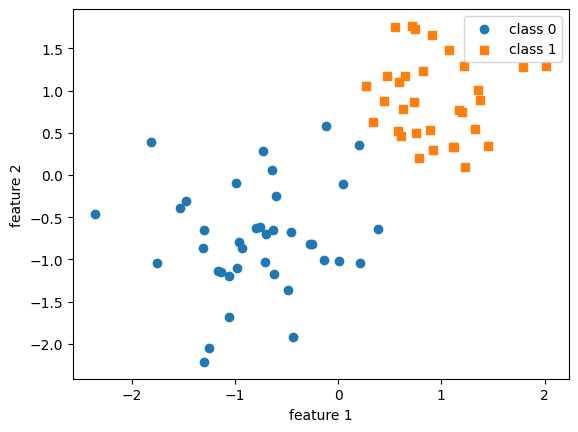

In [ ]:
plt.scatter(X_train[y_train==0, 0],X_train[y_train==0,1],label='class 0',marker='o')
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1],label='class 1',marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1,
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = torch.where(linear > 0,torch.ones_like(linear),torch.zeros_like(linear)).float()
        return predictions

    def backward(self, x, y):
        predictions = self.forward(x)
        errors = y - predictions
        return errors

    def train(self, x, y, epochs):
        for e in range(epochs):

            for i in range(y.size()[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)#view(1)是變成一維, view(-1)是自己看維度 （必須是在連續的記憶體）,不改變資料內部的原始資料
                self.weights += (errors * x[i]).view(self.num_features, 1)#.view從一維改成欄向量
                self.bias += errors

    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

In [ ]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

Model parameters:
  Weights: tensor([[1.2734],
        [1.3464]], device='cuda:0')
  Bias: tensor([-1.], device='cuda:0')


In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32,device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32,device=device)
test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' %(test_acc*100))

Test set accuracy: 93.33%


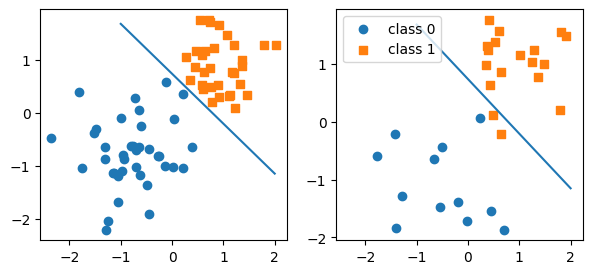

In [ ]:
w, b = ppn.weights.cpu(),ppn.bias.cpu()#這些資料在GPU但numpy and matplotlib 只能在cpu
x_min = -1
y_min =((-(w[0]*x_min)-b[0])/w[1])
x_max = 2
y_max = ((-(w[0]*x_max)-b[0])/w[1])
fig, ax = plt.subplots(1,2,sharex=True,figsize=(7,3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()